# Demo of EKF with Two-Stage Model

In [25]:
import numpy as np
import matplotlib.pyplot as plt

### Two-stage model functions

In [26]:
def bedtopo(L,*args):
    b0 = args[0]
    bx = args[1]
    sillmin = args[2]
    sillmax = args[3]
    sillslope = args[4]
    
    if L < sillmin:
        b = b0 + bx*L
    elif L < sillmax:
        b = b0 + bx*sillmin + sillslope*(L-sillmin)
    else:
        b = b0 + bx*sillmin + sillslope*(sillmax-sillmin) + bx*(L-sillmax)
        
    return b

In [27]:
def TwoStage_timedep(state,*args): #Robel et al. 2018 two-stage model
    
    Hnd, Lnd = state #Unpack the state vector
    f = np.zeros(2) #Derivatives
    
    smb0 = args[0]
    smb1 = args[1]
    smbf = args[2]
    gamma = args[3]
    omega = args[4]
    time = args[5]
    t1 = args[6]
    tfinal = args[7]
#    b0 = args[3]
#    bx = args[4]
#    sillmin = args[5]
#    sillmax = args[6]
#    sillslope = args[7]

    b0 = 0
    bx = -0.001
    sillmin = 415e3
    sillmax = 425e3
    sillslope = 0.01
    
    rhow = 1028
    rhoi = 917
    n = 3
    beta = 3.75
    Lscale = 100e3
    Hscale = 1000
    
    H = Hnd*Hscale
    L = Lnd*Lscale
    
    if time < t1:
        smb = smb0 + (smb1-smb0)*time/t1
    else:
        smb = smb1 + (smbf-smb1)*time/(tfinal-t1) 
    
    hg = -(rhow/rhoi)*bedtopo(L,b0,bx,sillmin,sillmax,sillslope)
    Q = gamma * (H**(2*n + 1))/(L**n)
    Qg = omega * (hg**beta)
    
    f[0] = (smb - (Qg/L) - (H/(hg*L))*(Q-Qg))/Hscale
    f[1] = (Q-Qg)/hg/Lscale
    return f 

### Time Integrator function

In [28]:
def RK4(rhs,state,dt,*args):
    
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args)

    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

### EKF functions

In [38]:
def EnKF(ubi,w,ObsOp,JObsOp,R,B):
    
    # The analysis step for the (stochastic) ensemble Kalman filter 
    # with virtual observations

    n,N = ubi.shape # n is the state dimension and N is the size of ensemble
    m = w.shape[0] # m is the size of measurement vector

    # compute the mean of forecast ensemble
    ub = np.mean(ubi,1)    
    # compute Jacobian of observation operator at ub
    Dh = JObsOp(w)
    # compute Kalman gain
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)
    Q=np.cov(ubi)
    ubi=ubi+np.random.multivariate_normal(np.zeros(n),Q,size=N).T   
    
    wi = np.zeros([m,N])
    uai = np.zeros([n,N])
    for i in range(N):
        # create virtual observations
        wi[:,i] = w + np.random.multivariate_normal(np.zeros(m), R)
        # compute analysis ensemble
        uai[:,i] = ubi[:,i] + K @ (wi[:,i]-ObsOp(ubi[:,i]))
        
    # compute the mean of analysis ensemble
    ua = np.mean(uai,1)    
    # compute analysis error covariance matrix
    P = (1/(N-1)) * (uai - ua.reshape(-1,1)) @ (uai - ua.reshape(-1,1)).T
    #not sure if I'll keep this in but might as well
    k = P.shape[0]
    ve = np.linalg.det(P)**(1/k)
    return uai, P, ve

In [30]:
# Observation operators
def h(u):
    w = u
    return w

def Dh(u):
    n = len(u)
    D = np.eye(n)
    return D

## Set parameters

In [7]:
nd = 2 #degrees of freedom (number of prognositic equations in model)
# parameters
smb0 = 0.3
smb1 = 0.15
smbf = 0.0
t1 = 1950
gamma = 0.05
omega = 8e-8
#b0 = 0
#bx = -0.001
#sillmin = 430e3
#sillmax = 440e3
#sillslope = 0.01

dt = 1
tm = 2300
nt = int(tm/dt)
t = np.linspace(0,tm,nt+1)

## Generating synthetic "truth" simulation

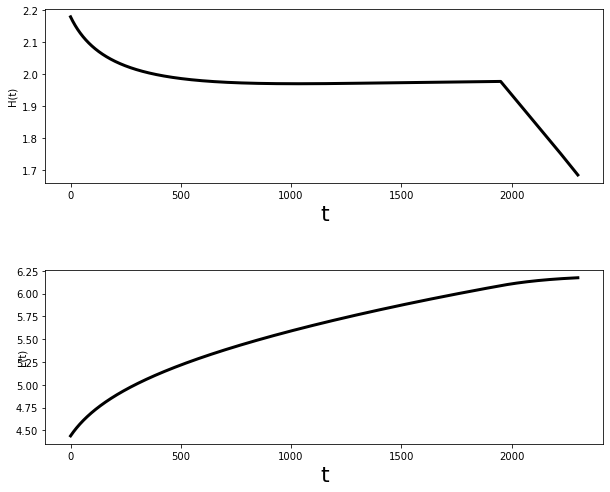

In [8]:
u0True = np.array([2.18,4.44]) # True initial conditions
#np.random.seed(seed=1)
sig_m_acc= 0.1  # standard deviation for accurate measurement noise
sig_m_inacc= 0.07  # standard deviation for inaccurate measurement noise

ind_m_inacc = np.linspace(200,1800,9).astype(int) #np.array([1000,1900])
ind_m_acc = np.linspace(2001,2020,20).astype(int)
ind_m = np.concatenate((ind_m_inacc,ind_m_acc))
t_m = t[ind_m]
nt_m = np.size(ind_m)
sig_m =  np.zeros(nt+1)
sig_m[ind_m_inacc] = sig_m_inacc
sig_m[ind_m_acc] = sig_m_acc

#time integration
uTrue = np.zeros([nd,nt+1])
uTrue[:,0] = u0True
km = 0
w = np.zeros([nd,nt_m])
for k in range(nt):
    time = k*dt
    uTrue[:,k+1] = RK4(TwoStage_timedep,uTrue[:,k],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm)
    if (km<nt_m) and (k+1==ind_m[km]):
        w[:,km] = h(uTrue[:,k+1]) + np.random.normal(0,sig_m[k+1],[nd,])
        km = km+1
        
fig, ax = plt.subplots(nrows=nd,ncols=1, figsize=(10,8))
ax = ax.flat
for k in range(nd):
    ax[k].plot(t,uTrue[k,:], label='True', linewidth = 3, color="black")
    ax[k].set_xlabel('t',fontsize=22)

ax[0].set_ylabel('H(t)', labelpad=5)
ax[1].set_ylabel('L(t)', labelpad=-12)
fig.subplots_adjust(hspace=0.5)

In [9]:
#save all "obs"
ind_m_all = ind_m
nt_m_all = nt_m
w_all = w
t_m_all = t_m
sig_m_all = sig_m

## Assimilation run: snapshot modern obs

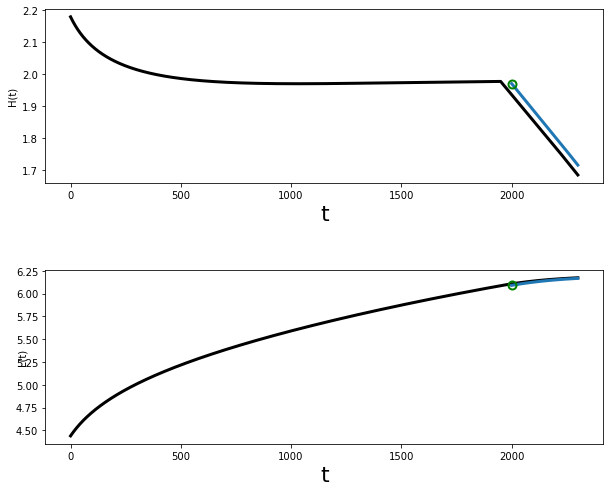

In [10]:
u0Snap = w_all[:,9] # wrong initial conditions
omega = 1.1*8e-8 #"wrong" parameter
#np.random.seed(seed=1)
sig_m_acc= 0.05  # standard deviation for accurate measurement noise
sig_m_inacc= 0.1  # standard deviation for accurate measurement noise

#time integration
ntsnap=300
tsnap = np.linspace(2000,2300,ntsnap+1)

uSnap = np.zeros([nd,ntsnap+1])
uSnap[:,0] = u0Snap

for k in range(ntsnap):
    time = tsnap[k]
    uSnap[:,k+1] = RK4(TwoStage_timedep,uSnap[:,k],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm)
        
fig, ax = plt.subplots(nrows=nd,ncols=1, figsize=(10,8))
ax = ax.flat
for k in range(nd):
    ax[k].plot(t,uTrue[k,:], label='True', linewidth = 3, color="black")
    ax[k].plot(tsnap,uSnap[k,:], label='Snapshot', linewidth = 3)
    ax[k].plot(tsnap[0],uSnap[k,0], 'o', fillstyle='none', label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
    
    ax[k].set_xlabel('t',fontsize=22)

ax[0].set_ylabel('H(t)', labelpad=5)
ax[1].set_ylabel('L(t)', labelpad=-12)
fig.subplots_adjust(hspace=0.5) 

## Assimilation run: many modern obs

### Set params an "wrong" initial conditions and parameters

In [11]:
u0b = np.array([2.3,4.7]) #"wrong" initial conditions (initial condition of simulation)
#omega = 0.9*8e-8 #"wrong" parameter
smb0 = 0.3
smb1 = 0.2

sig_b= 0.1
B = sig_b**2*np.eye(nd) #placeholder until first filter update
Q = 0.0*np.eye(nd)

#time integration
ub = np.zeros([nd,nt+1])
ub[:,0] = u0b
ua = np.zeros([nd,nt+1])
ua[:,0] = u0b

n = nd #state dimension
m = nd #measurement dimension

# ensemble size 
N = 10
#initialize ensemble
uai = np.zeros([nd,N])
uae = np.zeros([nd,N,nt+1])
for i in range(N):
    uai[:,i] = u0b + np.random.multivariate_normal(np.zeros(n), B)
    
## which obs to assimilate
obsub = range(9,nt_m_all)
w = w_all[:,obsub]
ind_m = ind_m_all[obsub]
nt_m = np.size(ind_m)
t_m = t_m_all[obsub]
sig_m =  np.zeros(nt+1)
sig_m[ind_m_acc] = sig_m_acc

### Run ensemble with assimilation

In [12]:
km = 0
for k in range(nt):
    time = k*dt
    # Forecast Step
    #background trajectory [without correction]
    ub[:,k+1] = RK4(TwoStage_timedep,ub[:,k],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm)
    #EnKF trajectory [with correction at observation times]
    for i in range(N): # forecast ensemble
        uai[:,i] = RK4(TwoStage_timedep,uai[:,i],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm)
        uae[:,i,k+1] = uai[:,i]

    # compute the mean of forecast ensemble
    ua[:,k+1] = np.mean(uai,1)
    # compute forecast error covariance matrix
    B = (1/(N-1)) * (uai - ua[:,k+1].reshape(-1,1)) @ (uai - ua[:,k+1].reshape(-1,1)).T

    if (km<nt_m) and (k+1==ind_m[km]):
        R = sig_m[k+1]**2*np.eye(nd) #covariance matrix for measurement noise

        # Analysis Step
        uai,B = EnKF(uai,w[:,km],h,Dh,R,B)
        # compute the mean of analysis ensemble
        ua[:,k+1] = np.mean(uai,1) 
        km = km+1

### Plot

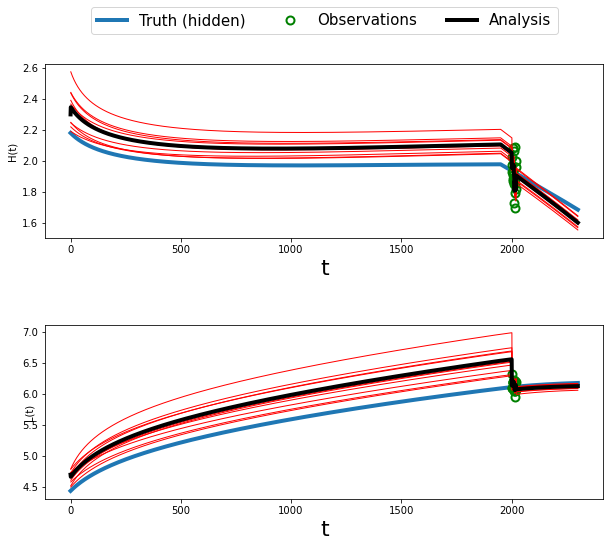

In [13]:
fig, ax = plt.subplots(nrows=nd,ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(nd):
    ax[k].plot(t,uTrue[k,:], label='Truth (hidden)', linewidth = 4)
    #ax[k].plot(t,ub[k,:], ':', label='Background', linewidth = 3)
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none', \
               label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
    ax[k].set_xlabel('t',fontsize=22)
    #ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)
    for j in range(N):
        ax[k].plot(t[1:],uae[k,j,1:], '-', linewidth = 1, color='r')
    ax[k].plot(t,ua[k,:], '-', label='Analysis', linewidth = 4, color = 'k')

ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)

ax[0].set_ylabel('H(t)', labelpad=5)
ax[1].set_ylabel('L(t)', labelpad=-12)
#ax[2].set_ylabel('z(t)')
fig.subplots_adjust(hspace=0.5)

w_modern = w
uae_modern = uae
ua_modern = ua
t_modern = t
ind_m_modern = ind_m

## Assimilation run: many modern obs + paleo

### Set params an "wrong" initial conditions and parameters

In [76]:
u0b = np.array([2.3,4.7]) #"wrong" initial conditions (initial condition of simulation)
#omega = 0.9*8e-8 #"wrong" parameter
smb0 = 0.3
smb1 = 0.2

sig_b= 0.1
B = sig_b**2*np.eye(nd) #placeholder until first filter update
Q = 0.0*np.eye(nd)

#time integration
ub = np.zeros([nd,nt+1])
ub[:,0] = u0b
ua = np.zeros([nd,nt+1])
ua[:,0] = u0b
p = np.zeros(nt)

n = nd #state dimension
m = nd #measurement dimension

# ensemble size 
N = 10
#initialize ensemble
uai = np.zeros([nd,N])
uae = np.zeros([nd,N,nt+1])
for i in range(N):
    uai[:,i] = u0b + np.random.multivariate_normal(np.zeros(n), B)
    
## which obs to assimilate
w = w_all
ind_m = ind_m_all
nt_m = nt_m_all
t_m = t_m_all
sig_m =  sig_m_all

### Run ensemble with assimilation

In [77]:
km = 0
for k in range(nt):
    time = k*dt
    # Forecast Step
    #background trajectory [without correction]
    ub[:,k+1] = RK4(TwoStage_timedep,ub[:,k],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm)
    #EnKF trajectory [with correction at observation times]
    for i in range(N): # forecast ensemble
        uai[:,i] = RK4(TwoStage_timedep,uai[:,i],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm)
        uae[:,i,k+1] = uai[:,i]

    # compute the mean of forecast ensemble
    ua[:,k+1] = np.mean(uai,1)
    # compute forecast error covariance matrix
    B = (1/(N-1)) * (uai - ua[:,k+1].reshape(-1,1)) @ (uai - ua[:,k+1].reshape(-1,1)).T
    if (km<nt_m) and (k+1==ind_m[km]):
        R = sig_m[k+1]**2*np.eye(nd) #covariance matrix for measurement noise

        # Analysis Step
        uai,B,ve = EnKF(uai,w[:,km],h,Dh,R,B)
        p[k]=ve
        # compute the mean of analysis ensemble
        ua[:,k+1] = np.mean(uai,1) 
        km = km+1

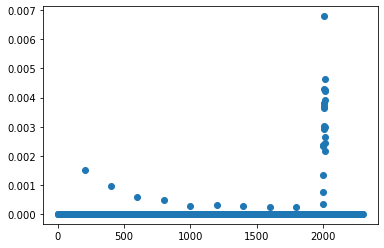

In [78]:
plt.scatter(t[1:],p)

### Plot

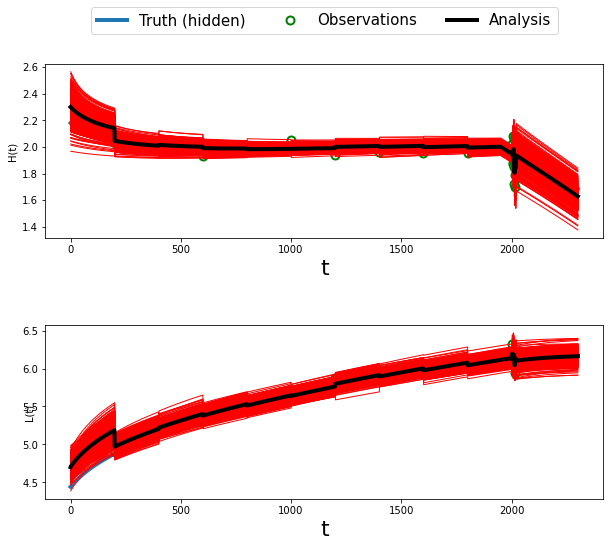

In [50]:
fig, ax = plt.subplots(nrows=nd,ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(nd):
    ax[k].plot(t,uTrue[k,:], label='Truth (hidden)', linewidth = 4)
    #ax[k].plot(t,ub[k,:], ':', label='Background', linewidth = 3)
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none', \
               label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
    ax[k].set_xlabel('t',fontsize=22)
    #ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)
    for j in range(N):
        ax[k].plot(t[1:],uae[k,j,1:], '-', linewidth = 1, color='r')
    ax[k].plot(t,ua[k,:], '-', label='Analysis', linewidth = 4, color = 'k')

ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)

ax[0].set_ylabel('H(t)', labelpad=5)
ax[1].set_ylabel('L(t)', labelpad=-12)
#ax[2].set_ylabel('z(t)')
fig.subplots_adjust(hspace=0.5)

w_all = w
uae_all = uae
ua_all = ua
t_all = t

## Assimilation run: many modern obs + paleo + parameter estimation

### Set params and "wrong" initial conditions and parameters

In [17]:
def TwoStage_timedep_withparam(state,*args): #Robel et al. 2018 two-stage model
    
    Hnd, Lnd, Ond = state #Unpack the state vector
    f = np.zeros(3) #Derivatives
    
    smb0 = args[0]
    smb1 = args[1]
    smbf = args[2]
    gamma = args[3]
    #omega = args[4]
    time = args[4]
    t1 = args[5]
    tfinal = args[6]
#    b0 = args[3]
#    bx = args[4]
#    sillmin = args[5]
#    sillmax = args[6]
#    sillslope = args[7]

    b0 = 0
    bx = -0.001
    sillmin = 415e3
    sillmax = 425e3
    sillslope = 0.01
    
    rhow = 1028
    rhoi = 917
    n = 3
    beta = 4.75
    Lscale = 100e3
    Hscale = 1000
    Oscale = 10e-8
    
    H = Hnd*Hscale
    L = Lnd*Lscale
    omega = Ond*Oscale
    
    if time < t1:
        smb = smb0 + (smb1-smb0)*time/t1
    else:
        smb = smb1 + (smbf-smb1)*time/(tfinal-t1) 
    
    hg = -(rhow/rhoi)*bedtopo(L,b0,bx,sillmin,sillmax,sillslope)
    Q = gamma * (H**(2*n + 1))/(L**n)
    Qg = omega * (hg**beta)
    
    f[0] = (smb - (Qg/L) - (H/(hg*L))*(Q-Qg))/Hscale
    f[1] = (Q-Qg)/hg/Lscale
    f[2] = 0
    return f 

In [18]:
# Observation operators
def h(u):
    w = u[0:2]
    return w

def Dh(u):
    n = len(u)
    D = np.hstack((np.eye(n),np.zeros((n,1))))
    return D

In [23]:
u0b = np.array([2.25,4.6,omega/10e-8]) #"wrong" initial conditions (initial condition of simulation)
nd=3;
#omega = 0.9*8e-8 #"wrong" parameter
smb0 = 0.3
smb1 = 0.2
smbf=0.0

sig_b= 0.1
B = sig_b**2*np.eye(nd) #placeholder until first filter update
Q = 0.0*np.eye(nd)

#time integration
ub = np.zeros([nd,nt+1])
ub[:,0] = u0b
ua = np.zeros([nd,nt+1])
ua[:,0] = u0b

n = nd #state dimension
m = 2 #measurement dimension

# ensemble size 
N = 10
#initialize ensemble
uai = np.zeros([nd,N])
uae = np.zeros([nd,N,nt+1])
for i in range(N):
    uai[:,i] = u0b + np.random.multivariate_normal(np.zeros(n), B)
    
## which obs to assimilate
w = w_all
ind_m = ind_m_all
nt_m = nt_m_all
t_m = t_m_all
sig_m =  sig_m_all

### Run ensemble with assimilation

In [24]:
km = 0
for k in range(nt):
    time = k*dt
    # Forecast Step
    #background trajectory [without correction]
    ub[:,k+1] = RK4(TwoStage_timedep_withparam,ub[:,k],dt,smb0,smb1,smbf,gamma,time,t1,tm)
    #EnKF trajectory [with correction at observation times]
    for i in range(N): # forecast ensemble
        uai[:,i] = RK4(TwoStage_timedep_withparam,uai[:,i],dt,smb0,smb1,smbf,gamma,time,t1,tm)
        uae[:,i,k+1] = uai[:,i]

    # compute the mean of forecast ensemble
    ua[:,k+1] = np.mean(uai,1)
    # compute forecast error covariance matrix
    B = (1/(N-1)) * (uai - ua[:,k+1].reshape(-1,1)) @ (uai - ua[:,k+1].reshape(-1,1)).T

    if (km<nt_m) and (k+1==ind_m[km]):
        R = sig_m[k+1]**2*np.eye(m) #covariance matrix for measurement noise

        # Analysis Step
        uai,B = EnKF(uai,w[:,km],h,Dh,R,B)
        # compute the mean of analysis ensemble
        ua[:,k+1] = np.mean(uai,1) 
        km = km+1

### Plot

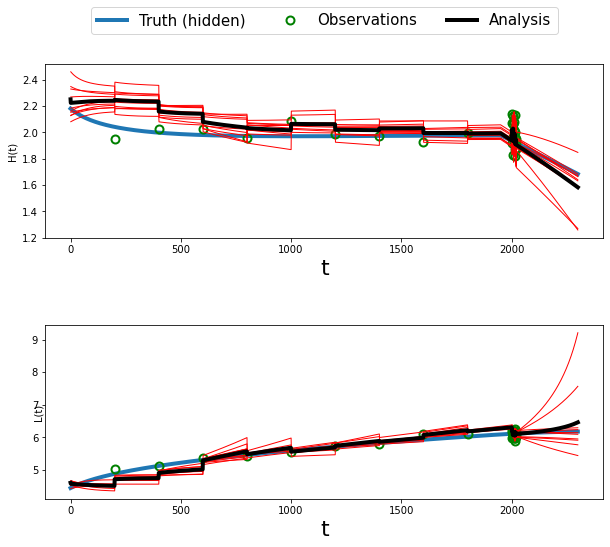

In [25]:
fig, ax = plt.subplots(nrows=nd-1,ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(nd-1):
    ax[k].plot(t,uTrue[k,:], label='Truth (hidden)', linewidth = 4)
    #ax[k].plot(t,ub[k,:], ':', label='Background', linewidth = 3)
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none', \
               label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
    ax[k].set_xlabel('t',fontsize=22)
    #ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)
    for j in range(N):
        ax[k].plot(t[1:],uae[k,j,1:], '-', linewidth = 1, color='r')
    ax[k].plot(t,ua[k,:], '-', label='Analysis', linewidth = 4, color = 'k')

ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)

ax[0].set_ylabel('H(t)', labelpad=5)
ax[1].set_ylabel('L(t)', labelpad=-12)
#ax[2].set_ylabel('z(t)')
fig.subplots_adjust(hspace=0.5)

w_param = w
uae_param = uae
ua_param = ua
t_param = t

## Plot all cases together

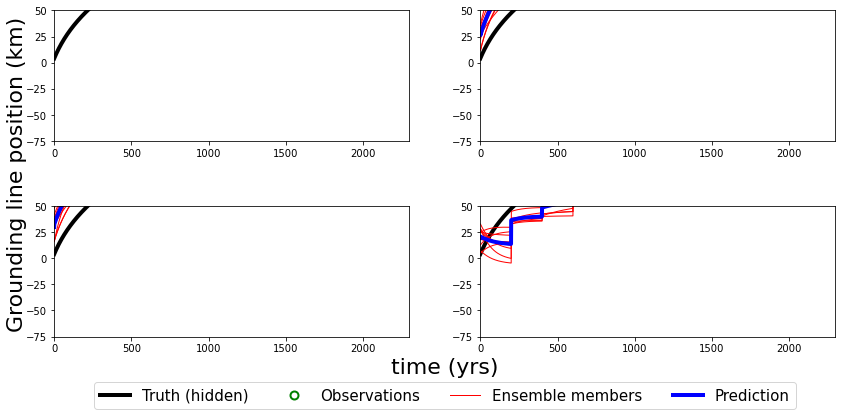

In [22]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(14,6))
ax = ax.flat
k=1
ax[0].plot(t,uTrue[k,:]*100 - 440, label='True', linewidth = 4, color="black")
ax[0].plot(tsnap,uSnap[k,:]*100 - 440, label='Prediction', linewidth = 4, color="blue")
ax[0].plot(tsnap[0],uSnap[k,0]*100 - 440, 'o', fillstyle='none', label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
#ax[0].set_ylabel('Grounding line position (km)')
#ax[0].set_title('Snapshot initialization with single obs.',fontsize=22)
ax[0].set_xlim(0,2300)
ax[0].set_ylim(-75,50)
fig.subplots_adjust(hspace=0.5) 

#modern obs assim
ax[1].plot(t_modern,uTrue[k,:]*100 - 440, label='Truth (hidden)', linewidth = 4, color="black")
ax[1].plot(t_modern[ind_m_modern],w_modern[k,:]*100 - 440, 'o', fillstyle='none', label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
for j in range(N):
    ax[1].plot(t_modern[1:],uae_modern[k,j,1:]*100 - 440, '-', linewidth = 1, color='r')
ax[1].plot(t_modern,ua_modern[k,:]*100 - 440, '-', label='Prediction', linewidth = 4, color="blue")
#ax[1].set_ylabel('Grounding line position (km)')
#ax[1].set_title('EKF assimilating modern obs.')
ax[1].set_xlim(0,2300)
ax[1].set_ylim(-75,50)
fig.subplots_adjust(hspace=0.5) 

#all obs assim
ax[2].plot(t,uTrue[k,:]*100 - 440, label='Truth (hidden)', linewidth = 4, color="black")
ax[2].plot(t_all[ind_m],w_all[k,:]*100 - 440, 'o', fillstyle='none', label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
#ax[2].set_xlabel('t',fontsize=22)
for j in range(N):
    ax[2].plot(t_all[1:],uae_all[k,j,1:]*100 - 440, '-', linewidth = 1, color='r')
ax[2].plot(t_all[1:],uae_all[k,N-1,1:]*100 - 440, '-', linewidth = 1, color='r', label="Ensemble members")
ax[2].plot(t_all,ua_all[k,:]*100 - 440, '-', label='Prediction', linewidth = 4, color="blue")
#ax[2].set_ylabel('Grounding line position (km)')
#ax[2].set_title('EKF assimilating modern/paleo obs.')
ax[2].set_xlim(0,2300)
ax[2].set_ylim(-75,50)
fig.subplots_adjust(hspace=0.5) 

#all obs assim
ax[3].plot(t,uTrue[k,:]*100 - 440, label='Truth (hidden)', linewidth = 4, color="black")
ax[3].plot(t_all[ind_m],w_param[k,:]*100 - 440, 'o', fillstyle='none', label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')
#ax[3].set_xlabel('t',fontsize=22)
for j in range(N):
    ax[3].plot(t_all[1:],uae_param[k,j,1:]*100 - 440, '-', linewidth = 1, color='r')
ax[3].plot(t_all[1:],uae_param[k,N-1,1:]*100 - 440, '-', linewidth = 1, color='r', label="Ensemble members")
ax[3].plot(t_all,ua_param[k,:]*100 - 440, '-', label='Prediction', linewidth = 4, color="blue")
#ax[3].set_xlabel('time (years)',fontsize=22)
#ax[3].set_ylabel('Grounding line position (km)')
#ax[3].set_title('EKF assimilating modern/paleo obs. + parameter estimation')
ax[3].set_xlim(0,2300)
ax[3].set_ylim(-75,50)
fig.subplots_adjust(hspace=0.5) 

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.xlabel("time (yrs)", fontsize=22)
plt.ylabel("Grounding line position (km)", fontsize=22)

ax[3].legend(loc="center", bbox_to_anchor=(-0.1,-0.45),ncol =4,fontsize=15)